### 1. Install dependencies
The training was done on google colab on T4 GPU

In [ ]:
#! pip install tensorflow==2.18.0 scipy==1.14.1 numpy==2.0.2 matplotlib==3.10.0

In [ ]:
! pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.5.2
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.23
albumentations                        2.0.5
ale-py                                0.10.2
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.1
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.21.0.37.6
astunparse                            1.6.3
atpublic                              5.1

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Data loading and preprocessing
Decode and cast the images into grayscale, make sure the image is in 512p x 512p then split to input/output pairs (second/first image) input is (512,512,1) (single channel)

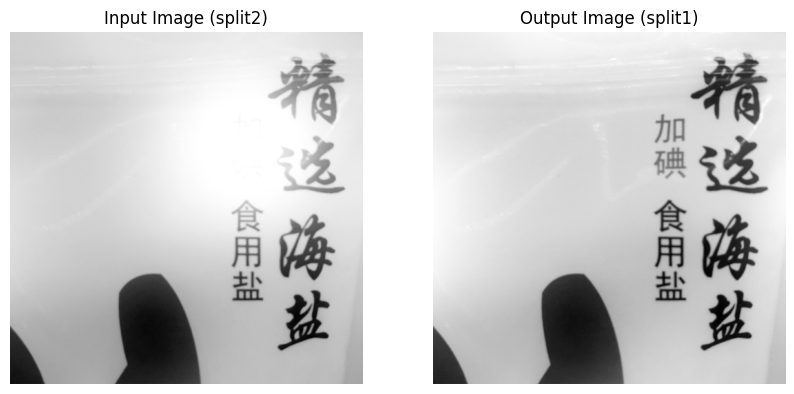

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def parse_image(file_path):
    '''
    parse_image function to read and preprocess the image
    :param file_path: path to the image file
    :return: tuple of (input image, output image)
    
    '''
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1) 
    img = tf.cast(img, tf.float32) / 255.0

    # Split 1024-width image into left/right halves
    split1 = img[:, :512, :]   # Output (left)
    split2 = img[:, 512:1024, :]  # Input (right)

    return split2, split1  # Return input, output

def load_data(data_dir):
    '''
    load_data function to load and preprocess the dataset
    :param data_dir: directory containing the dataset
    :return: tf.data.Dataset object
    '''
    file_paths = tf.data.Dataset.list_files(data_dir + '/*.png')

    def map_to_pair(file_path):
        return parse_image(file_path)

    dataset = file_paths.map(map_to_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_data('/content/drive/MyDrive/interview_HTX/SD1_Trimmed/train')
val_dataset = load_data('/content/drive/MyDrive/interview_HTX/SD1_Trimmed/val')

# Visualization
for image_batch, label_batch in train_dataset.take(1):
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_batch[0].squeeze(), cmap='gray')
    plt.title("Input Image (split2)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label_batch[0].squeeze(), cmap='gray')
    plt.title("Output Image (split1)")
    plt.axis('off')

    plt.show()


In [ ]:
import matplotlib.pyplot as plt

def model_metrics(history):
    '''
    model_metrics function to plot the training history
    :param history: training history object
    :return: None
    '''
    # Create a figure with a single axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the training and validation loss on the first y-axis (left)
    ax1.plot(history.history['loss'], label='Train Loss', color='b')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='r')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis for MAE (L1 Loss)
    ax2 = ax1.twinx()
    ax2.plot(history.history['mae'], label='Train MAE (L1 Loss)', color='g')
    ax2.plot(history.history['val_mae'], label='Val MAE (L1 Loss)', color='y', linestyle='--')
    ax2.set_ylabel('L1 Loss (MAE)', color='g')
    ax2.tick_params(axis='y', labelcolor='g')

    # Add a title and a legend
    fig.suptitle('Training History: Loss and MAE')
    fig.tight_layout()  # Adjust layout to prevent overlap

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show the plot
    plt.show()

### 3. Build the models
We use a U-Net Encoder as the base model

Assumptions: Model should be at most 100MB, only 1 network can be used, but we can decide on the loss function

For the model we attempt to train the U-Net on 2 different types of losses:
  - Mean absolute error
  - Text perceptual loss (Hou et al., 2021), using pretrained MobileNetV2 and Densenet

For the training process, we use - 4 encoders, 1 bottleneck, 4 Decoders as the default for the Unet encoder, mean absolute error loss is the loss, optimizer is adam, we train up to 10 epochs due to computing resource constraints (3-5 mins/epoch on colab T4)

##### 3.1 U-Net + Mean absolute error loss

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 361s 662ms/step - loss: 0.0187 - mae: 0.1002 - val_loss: 0.0055 - val_mae: 0.0489
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 223s 585ms/step - loss: 0.0058 - mae: 0.0519 - val_loss: 0.0043 - val_mae: 0.0464
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 581ms/step - loss: 0.0036 - mae: 0.0416 - val_loss: 0.0031 - val_mae: 0.0442
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 223s 583ms/step - loss: 0.0025 - mae: 0.0358 - val_loss: 0.0019 - val_mae: 0.0297
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 221s 582ms/step - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0032 - val_mae: 0.0366
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 222s 583ms/step - loss: 0.0017 - mae: 0.0284 - val_loss: 0.0012 - val_mae: 0.0238
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 578ms/step - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0011 - val_mae: 0.0232
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 262s 579ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0013 - val_mae: 0.0239
Epoch 9/10
375/375 ━━━━━

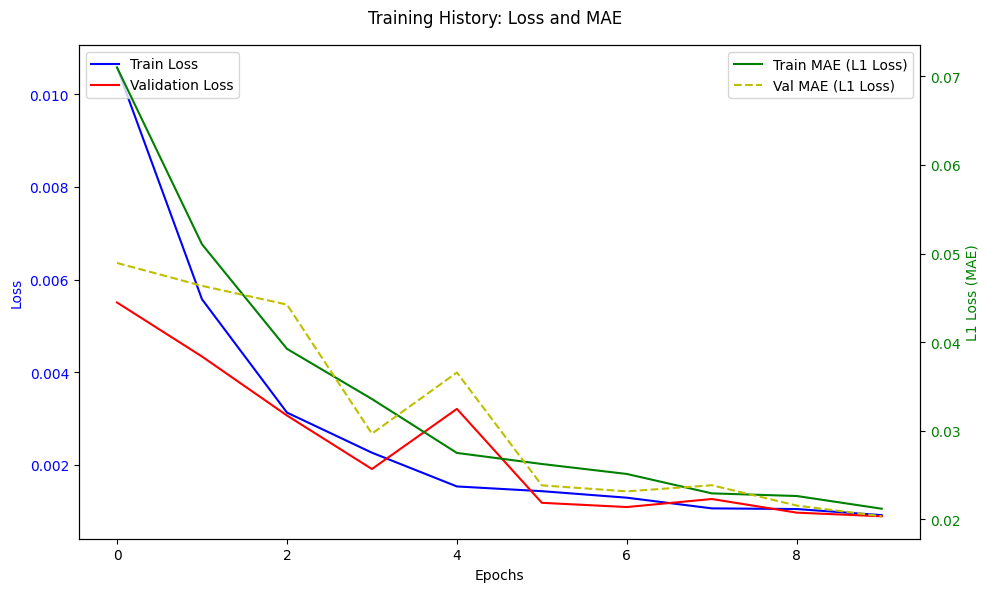

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
def build_unet(input_shape=(512, 512, 1)):
    '''
    build_unet function to create a U-Net model
    :param input_shape: shape of the input image
    :return: U-Net model (tf.keras.Model)
    '''
    def conv_block(x, filters):
        '''
        conv_block function to create a convolutional block
        :param x: input tensor
        :param filters: number of filters for the convolutional layers
        :return: output tensor after applying two convolutional layers
        '''
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        return x

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return models.Model(inputs, outputs)

unet = build_unet()
unet.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

unet.save('/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet.h5')
model_metrics(history)

Input batch shape: (8, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


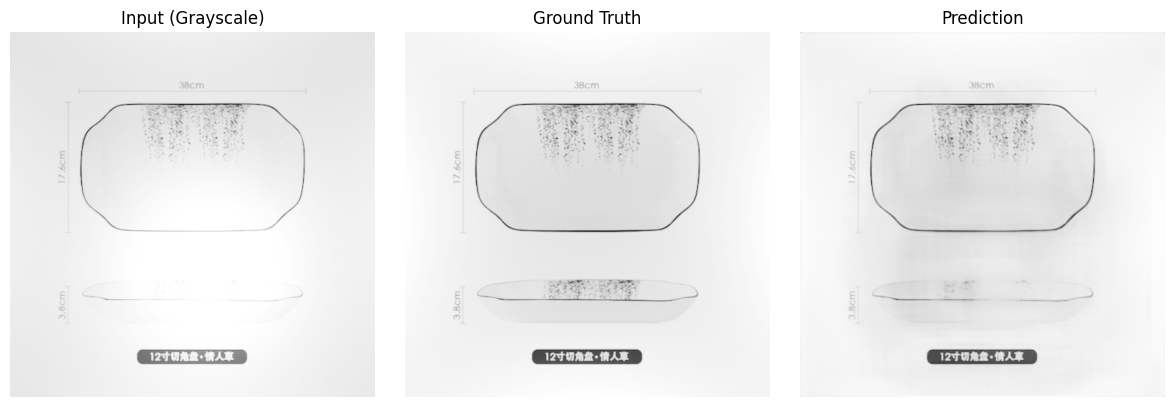

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take a batch from the validation dataset
model_path = '/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet.h5'
model = tf.keras.models.load_model(model_path)
for input_batch, output_batch in val_dataset.take(1):
    # Check the shape of input_batch
    print("Input batch shape:", input_batch.shape)

    # If the input batch has 3 channels (RGB), convert to grayscale
    if input_batch.shape[-1] == 3:
        grayscale_input_batch = tf.image.rgb_to_grayscale(input_batch)
    else:
        # If it's already grayscale, no need to convert
        grayscale_input_batch = input_batch

    # Resize to ensure the shape is 512x512 (if necessary)
    grayscale_input_batch = tf.image.resize(grayscale_input_batch, (512, 512))

    # model unet prediction testing
    predictions = model.predict(grayscale_input_batch)
    break


# Visualize the results (input, output, prediction unet)
plt.figure(figsize=(12, 4))

# Input image (grayscale)
plt.subplot(1, 3, 1)
plt.title("Input (Grayscale)")
plt.imshow(grayscale_input_batch[0, :, :, 0], cmap='gray')  # Only plot the grayscale channel
plt.axis('off')

# Ground truth (original)
plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(output_batch[0, :, :, 0], cmap='gray')  # Assuming output is grayscale as well
plt.axis('off')

# Prediction-unet
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(predictions[0, :, :, 0], cmap='gray')  # Assuming prediction is grayscale
plt.axis('off')

plt.tight_layout()
plt.show()



##### 3.2 U-Net + Text perceptual loss

In [ ]:
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping

def build_unet(input_shape=(512, 512, 1)):
    '''
    build_unet function to create a U-Net model
    :param input_shape: shape of the input image
    :return: U-Net model (tf.keras.Model)
    '''
    def conv_block(x, filters):
        '''
        conv_block function to create a convolutional block
        :param x: input tensor
        :param filters: number of filters for the convolutional layers
        :return: output tensor after applying two convolutional layers
        '''
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        return x

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 64); p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 128); p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 256); p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return models.Model(inputs, outputs)

# Build and Compile the U-Net
unet = build_unet()

# CTPN not in Keras, using similar mobileNetV2
feature_extractor_ctpn = applications.MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
feature_extractor_densenet = applications.DenseNet121(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

# Choose layers to extract features from
selected_layers_ctpn = ["block_3_expand_relu", "block_6_expand_relu", "block_13_expand_relu"]  # P3
selected_layer_densenet = "conv5_block16_concat"  # just one for DenseNet

# Get the feature extraction layers
outputs_ctpn = [feature_extractor_ctpn.get_layer(name).output for name in selected_layers_ctpn]
model_ctpn = models.Model(inputs=feature_extractor_ctpn.input, outputs=outputs_ctpn)

output_densenet = feature_extractor_densenet.get_layer(selected_layer_densenet).output
model_densenet = models.Model(inputs=feature_extractor_densenet.input, outputs=output_densenet)

# Freeze feature extractors
model_ctpn.trainable = False
model_densenet.trainable = False

def text_perceptual_loss(y_true, y_pred):
    '''
    text perceptual loss (Hou et al., 2021)
    sum of (kφc(Iout) − φc(Igt)k1) + kφd(Iout) − φd(Igt)k1
    :param y_true: ground truth image
    :param y_pred: predicted image
    '''
    # stack grayscale to 3 channels
    if y_true.shape[-1] == 1:
        y_true_rgb = tf.image.grayscale_to_rgb(y_true)
        y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)
    else:
        y_true_rgb = y_true
        y_pred_rgb = y_pred

    # Extract features per layer (ctpn and densenet)
    true_feats_ctpn = model_ctpn(y_true_rgb)
    pred_feats_ctpn = model_ctpn(y_pred_rgb)
    true_feats_densenet = model_densenet(y_true_rgb)
    pred_feats_densenet = model_densenet(y_pred_rgb)

    # Compute loss: sum of L1 distances
    ctpn_loss = 0
    for true_feat, pred_feat in zip(true_feats_ctpn, pred_feats_ctpn):
        ctpn_loss += tf.reduce_mean(tf.abs(true_feat - pred_feat))

    densenet_loss = tf.reduce_mean(tf.abs(true_feats_densenet - pred_feats_densenet))

    total_loss = ctpn_loss + densenet_loss
    return total_loss

unet.compile(optimizer='adam', loss=text_perceptual_loss, metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

unet.save('/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet_text_perceptual.h5')



<ipython-input-4-ca5890675a0b>:75: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor_ctpn = applications.MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - loss: 0.2353 - mae: 0.0876 - val_loss: 0.1026 - val_mae: 0.0540
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 342s 892ms/step - loss: 0.1079 - mae: 0.0584 - val_loss: 0.0941 - val_mae: 0.0515
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 341s 891ms/step - loss: 0.0958 - mae: 0.0465 - val_loss: 0.0876 - val_mae: 0.0410
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 342s 892ms/step - loss: 0.0874 - mae: 0.0376 - val_loss: 0.0791 - val_mae: 0.0329
Epoch 5/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 342s 893ms/step - loss: 0.0804 - mae: 0.0321 - val_loss: 0.0778 - val_mae: 0.0340
Epoch 6/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 341s 891ms/step - loss: 0.0788 - mae: 0.0318 - val_loss: 0.0749 - val_mae: 0.0305
Epoch 7/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 343s 891ms/step - loss: 0.0794 - mae: 0.0309 - val_loss: 0.0736 - val_mae: 0.0295
Epoch 8/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 342s 893m

NameError: name 'model_matrics' is not defined

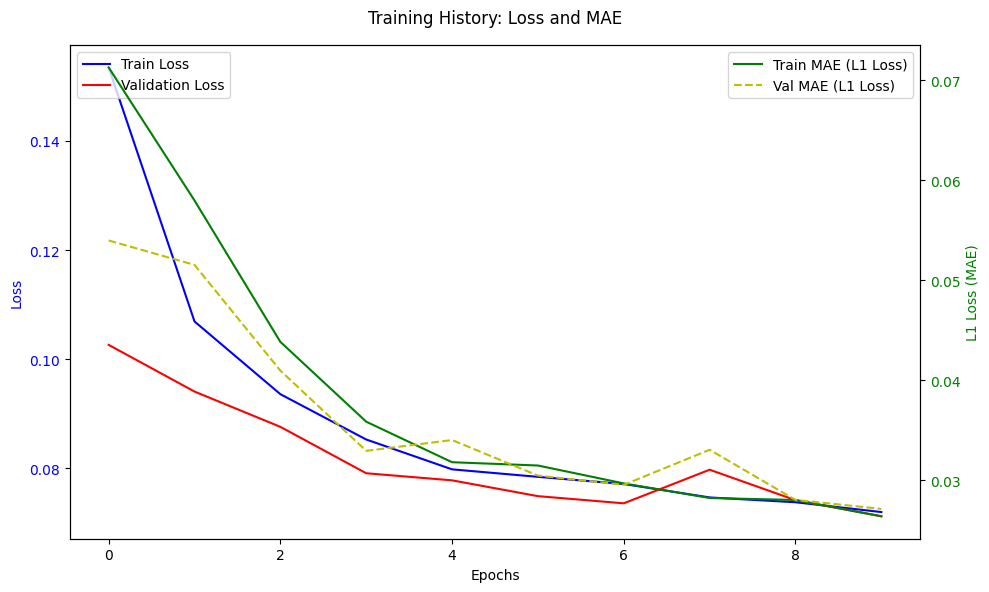

In [ ]:
model_metrics(history)

### 4. Demonstration of model's performance on a random image
  - Mean absolute error
  - Text perceptual loss (Hou et al., 2021)

Input batch shape: (8, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


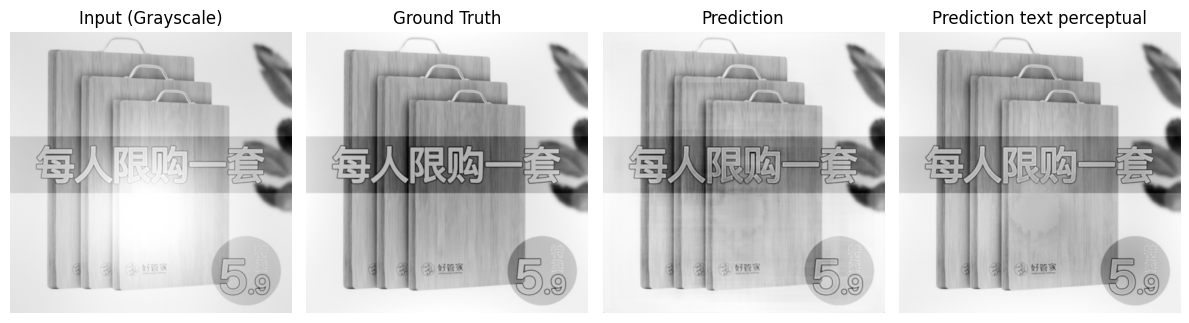

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the model and visualize predictions
model_unet_path = '/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet.h5'
model_unet_text_loss_path='/content/drive/MyDrive/interview_HTX/bright_spot_removal_unet_text_perceptual.h5'
model_unet = tf.keras.models.load_model(model_unet_path)
model_unet_text_loss = tf.keras.models.load_model(model_unet_text_loss_path,custom_objects={"text_perceptual_loss": text_perceptual_loss})
for input_batch, output_batch in val_dataset.take(1):
    # validate input batch to be 512,512,1
    print("Input batch shape:", input_batch.shape)
    # convert to grayscale
    if input_batch.shape[-1] == 3:
        grayscale_input_batch = tf.image.rgb_to_grayscale(input_batch)
    else:
        grayscale_input_batch = input_batch

    # Resize to ensure the shape is 512x512 (if necessary)
    grayscale_input_batch = tf.image.resize(grayscale_input_batch, (512, 512))

    # model unet prediction testing
    predictions_unet = model_unet.predict(grayscale_input_batch)
    predictions_unet_text_perceptual=model_unet_text_loss.predict(grayscale_input_batch)
    break

# Visualize the results (input, output, prediction unet, prediction unet with text perceptual loss)
plt.figure(figsize=(12, 4))

# Input image (grayscale)
plt.subplot(1, 4, 1)
plt.title("Input (Grayscale)")
plt.imshow(grayscale_input_batch[0, :, :, 0], cmap='gray')
plt.axis('off')

# Ground truth (original)
plt.subplot(1, 4, 2)
plt.title("Ground Truth")
plt.imshow(output_batch[0, :, :, 0], cmap='gray')
plt.axis('off')

# Prediction-unet
plt.subplot(1, 4, 3)
plt.title("Prediction")
plt.imshow(predictions_unet[0, :, :, 0], cmap='gray')
plt.axis('off')

# Prediction-unet-text-perceptual-loss
plt.subplot(1, 4, 4)
plt.title("Prediction text perceptual")
plt.imshow(predictions_unet_text_perceptual[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


### 5. Conclusion
The text-perceptual loss (Hou et al., 2021) would excel in preserving more high level features as compared with mean absolute error (mae), which focuses on pixel level comparisons, By visual comparison, both loss methods are viable in glare suppression, however, the intensity of glare suppression would be much higher for the model trained on mae loss. Intuitively, this would seem to be a better option for glare suppression. However, as revealed by then results, it would cause smudges/distortions in certain areas that were glare suppressed such as `009_enhanced.png` in the folder `/predictions_mae`, where the result looked way worse than the `009_enhanced.png` in the folder `/predictions` as we are taking the mean value of each pixel. This is because of high sensitivity of the MAE loss function to pixel level details. For the text-perceptual loss, although the glare may not be suppressed completely, it is still sufficient enough such that the higher level features (words/patterns) are well-preserved.